![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 3. Training and Reusing Named Entity Recognition Models

## Related blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 3.4.0
Apache Spark version: 3.2.0
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.0 
 Master 
 spark://10.139.64.5:7077 
 AppName 
 Databricks Shell

## CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
 Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
 BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
training_data.cache()

Out[6]: DataFrame[text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, label: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [0]:
%time training_data.count()

CPU times: user 28 ms, sys: 9.6 ms, total: 37.6 ms
Wall time: 7.9 s
Out[7]: 14041

In [0]:
%time training_data.count()

CPU times: user 1.4 ms, sys: 4.71 ms, total: 6.11 ms
Wall time: 1.15 s
Out[8]: 14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
 token|pos|ner_label|
+----------+---+---------+
 EU|NNP| B-ORG|
 rejects|VBZ| O|
 German| JJ| B-MISC|
 call| NN| O|
 to| TO| O|
 boycott| VB| O|
 British| JJ| B-MISC|
 lamb| NN| O|
 .| .| O|
 Peter|NNP| B-PER|
 Blackburn|NNP| I-PER|
 BRUSSELS|NNP| B-LOC|
1996-08-22| CD| O|
 The| DT| O|
 European|NNP| B-ORG|
Commission|NNP| I-ORG|
 said|VBD| O|
 on| IN| O|
 Thursday|NNP| O|
 it|PRP| O|
+----------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
ground_truth|count |
+------------+------+
O |169578|
B-LOC |7140 |
B-PER |6600 |
B-ORG |6321 |
I-PER |4528 |
I-ORG |3704 |
B-MISC |3438 |
I-LOC |1157 |
I-MISC |1155 |
+------------+------+

In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
%fs mkdirs dbfs:/ner_logs

res1: Boolean = true

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(1)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setOutputLogsPath("dbfs:/ner_logs") # if not set, logs will be written to ~/annotator_logs
 #.setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 # .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])


### Fitting

In [0]:
ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 1.5 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

In [0]:
%sh cd /dbfs/ner_logs && pwd && ls -l

/dbfs/ner_logs
total 1
-rwxrwxrwx 1 root root 1013 Feb 8 19:10 NerDLApproach_faab34fe80db.log

In [0]:
%sh head -n 45 /dbfs/ner_logs/NerDLApproach_*

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11172


Epoch 1/1 started, lr: 0.003, dataset size: 11172


Epoch 1/1 - 77.15s - loss: 1098.4905 - batches: 352
Quality on validation dataset (20.0%), validation examples = 2234
time to finish evaluation: 5.50s
label tp fp fn prec rec f1
B-LOC 1237 46 169 0.96414655 0.87980086 0.9200446
I-ORG 598 107 193 0.84822696 0.75600505 0.7994652
I-MISC 112 44 114 0.71794873 0.49557522 0.5863874
I-LOC 150 12 83 0.9259259 0.64377683 0.7594937
I-PER 797 50 18 0.9409681 0.9779141 0.95908546
B-MISC 582 107 126 0.8447025 0.8220339 0.83321404
B-ORG 1093 222 168 0.8311787 0.8667724 0.84860253
B-PER 1181 148 43 0.8886381 0.96486926 0.92518604
tp: 5750 fp: 736 fn: 914 labels: 8
Macro-average prec: 0.8702169, rec: 0.8008435, f1: 0.8340902
Micro-average prec: 0.8865248, rec: 0.8628451, f1: 0.8745247

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings| ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
 result| result| result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...| [O, O, B-ORG, O, O, O, O, O, O, O, O]| [O, O, B-ORG, O, O, O, O, O, O, O, O]|
 [LONDON, 1996-08-30]| [B-LOC, O]| [B-LOC, O]|
[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-LOC, B-MISC, O, B-PER, I-PER, O, O, O, O, O,...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
token |ground_truth|prediction|
+--------------+------------+----------+
CRICKET |O |O |
- |O |O |
LEICESTERSHIRE|B-ORG |B-ORG |
TAKE |O |O |
OVER |O |O |
AT |O |O |
TOP |O |O |
AFTER |O |O |
INNINGS |O |O |
VICTORY |O |O |
. |O |O |
LONDON |B-LOC |B-LOC |
1996-08-30 |O |O |
West |B-MISC |B-LOC |
Indian |I-MISC |B-MISC |
all-rounder |O |O |
Phil |B-PER |B-PER |
Simmons |I-PER |I-PER |
took |O |O |
four |O |O |
+--------------+------------+----------+
only showing top 20 rows

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


precision recall f1-score support

 B-LOC 0.96 0.86 0.91 1837
 B-MISC 0.86 0.83 0.84 922
 B-ORG 0.80 0.87 0.83 1341
 B-PER 0.91 0.97 0.94 1842
 I-LOC 0.96 0.54 0.69 257
 I-MISC 0.80 0.53 0.64 346
 I-ORG 0.81 0.70 0.75 751
 I-PER 0.96 0.97 0.96 1307
 O 0.99 1.00 0.99 42759

 accuracy 0.97 51362
 macro avg 0.89 0.81 0.84 51362
weighted avg 0.97 0.97 0.97 51362

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 6034 phrases; correct: 5164.
accuracy: 86.14%; (non-O)
accuracy: 97.45%; precision: 85.58%; recall: 86.91%; FB1: 86.24
 LOC: precision: 94.66%; recall: 85.85%; FB1: 90.04 1666
 MISC: precision: 79.96%; recall: 78.31%; FB1: 79.12 903
 ORG: precision: 73.16%; recall: 81.51%; FB1: 77.11 1494
 PER: precision: 89.90%; recall: 96.20%; FB1: 92.95 1971

In [0]:
# micro, macro, avg
metrics[0]

Out[26]: (85.58170367915147, 86.9067653988556, 86.23914495657982)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[27]:

,entity,precision,recall,f1,support
0,LOC,94.657863,85.846489,90.037111,1666
1,MISC,79.955703,78.308026,79.123288,903
2,ORG,73.159304,81.506339,77.107584,1494
3,PER,89.903602,96.199783,92.945188,1971


### Splitting dataset into train and test

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9739
Test Dataset Count: 4302

Let's save our `test_data` as parquet by transforming with embeddings.

In [0]:
glove_embeddings.transform(test_data).write.parquet('dbfs/nerdl_test.parquet')

In [0]:
%fs mkdirs dbfs:/ner_logs_best

Let's use `setUseBestModel(True)` parameter to restore the model with the best performance at the end of the training and use the `setTestDataset` parameter to calculate statistical measures for each epoch during training

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setUseBestModel(True)\
  .setTestDataset('dbfs:/nerdl_test.parquet')\
  .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])

In [0]:
ner_model = ner_pipeline.fit(training_data)

In [0]:
%sh cd /dbfs/ner_logs_best && pwd && ls -l

/dbfs/ner_logs_best
total 8
-rwxrwxrwx 1 root root 7773 Feb 8 19:24 NerDLApproach_5823cf36e8f2.log

In [0]:
%sh cat /dbfs/ner_logs_best/NerDLApproach_*.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7824


Epoch 1/5 started, lr: 0.003, dataset size: 7824


Epoch 1/5 - 59.39s - loss: 1015.5033 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1564
time to finish evaluation: 3.80s
label tp fp fn prec rec f1
B-LOC 920 262 37 0.77834177 0.9613375 0.860215
I-ORG 305 54 148 0.8495822 0.6732892 0.75123155
I-MISC 87 72 58 0.5471698 0.6 0.57236844
I-LOC 105 28 48 0.7894737 0.6862745 0.7342657
I-PER 580 28 12 0.95394737 0.9797297 0.9666667
B-MISC 358 66 114 0.8443396 0.7584746 0.79910713
B-ORG 568 70 274 0.89028215 0.6745843 0.7675675
B-PER 826 44 64 0.9494253 0.9280899 0.93863636
tp: 3749 fp: 624 fn: 755 labels: 8
Macro-average prec: 0.82532024, rec: 0.7827225, f1: 0.80345714
Micro-average prec: 0.8573062, rec: 0.83237123, f1: 0.8446547
Quality on test dataset: 
time to finish evaluation: 7.25s
label tp fp fn prec rec f1
B-LOC 2052 621 107 0.7676768 0.95044 0.84933776
I-ORG 772 131 375 0.854928 0.6730602 0.7531707
I-MISC 248 143 131 0.6342711 0.65435356 0.64415586
I-LOC 247 91 102 0.7307692 0.7077364 0.71906835
I-PER 1406 49 40 0.966323 0.9723375 0.9693209
B-MISC 801 167 246 0.82747936 0.76504296 0.79503715
B-ORG 1246 170 680 0.8799435 0.64693666 0.74566126
B-PER 1912 102 130 0.9493545 0.93633693 0.9428008
tp: 8684 fp: 1474 fn: 1811 labels: 8
Macro-average prec: 0.8263432, rec: 0.78828055, f1: 0.8068632
Micro-average prec: 0.8548927, rec: 0.82744163, f1: 0.8409432


Epoch 2/5 started, lr: 0.0029850747, dataset size: 7824


Epoch 2/5 - 51.01s - loss: 339.487 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1564
time to finish evaluation: 3.15s
label tp fp fn prec rec f1
B-LOC 913 95 44 0.90575397 0.954023 0.9292621
I-ORG 374 59 79 0.86374134 0.82560706 0.8442437
I-MISC 97 32 48 0.751938 0.6689655 0.7080292
I-LOC 128 29 25 0.81528664 0.8366013 0.8258065
I-PER 579 16 13 0.97310925 0.9780405 0.97556865
B-MISC 416 105 56 0.7984645 0.88135594 0.83786505
B-ORG 744 105 98 0.8763251 0.8836104 0.87995267
B-PER 852 45 38 0.9498328 0.95730335 0.9535534
tp: 4103 fp: 486 fn: 401 labels: 8
Macro-average prec: 0.86680645, rec: 0.8731884, f1: 0.8699857
Micro-average prec: 0.8940946, rec: 0.910968, f1: 0.90245247
Quality on test dataset: 
time to finish evaluation: 6.97s
label tp fp fn prec rec f1
B-LOC 2048 243 111 0.89393276 0.9485873 0.9204495
I-ORG 929 187 218 0.8324373 0.80993897 0.821034
I-MISC 250 65 129 0.7936508 0.6596306 0.7204611
I-LOC 289 77 60 0.7896175 0.82808024 0.80839163
I-PER 1412 33 34 0.97716266 0.97648686 0.97682464
B-MISC 910 240 137 0.79130435 0.8691499 0.8284024
B-ORG 1637 278 289 0.85483027 0.8499481 0.8523822
B-PER 1961 116 81 0.9441502 0.960333 0.9521728
tp: 9436 fp: 1239 fn: 1059 labels: 8
Macro-average prec: 0.85963583, rec: 0.86276937, f1: 0.86119974
Micro-average prec: 0.88393444, rec: 0.8990948, f1: 0.8914501


Epoch 3/5 started, lr: 0.0029702971, dataset size: 7824


Epoch 3/5 - 50.29s - loss: 249.12161 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1564
time to finish evaluation: 3.13s
label tp fp fn prec rec f1
B-LOC 939 188 18 0.83318543 0.9811912 0.90115166
I-ORG 312 42 141 0.88135594 0.68874174 0.77323425
I-MISC 83 6 62 0.9325843 0.5724138 0.7094018
I-LOC 138 138 15 0.5 0.9019608 0.6433566
I-PER 585 47 7 0.9256329 0.9881757 0.9558824
B-MISC 384 26 88 0.93658537 0.8135593 0.8707482
B-ORG 664 48 178 0.9325843 0.7885986 0.8545689
B-PER 858 102 32 0.89375 0.9640449 0.92756754
tp: 3963 fp: 597 fn: 541 labels: 8
Macro-average prec: 0.8544598, rec: 0.8373358, f1: 0.8458112
Micro-average prec: 0.86907893, rec: 0.87988454, f1: 0.8744484
Quality on test dataset: 
time to finish evaluation: 8.72s
label tp fp fn prec rec f1
B-LOC 2084 492 75 0.8090062 0.9652617 0.8802534
I-ORG 764 126 383 0.858427 0.6660854 0.7501227
I-MISC 209 25 170 0.89316237 0.5514512 0.68189234
I-LOC 325 4

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


precision recall f1-score support

 B-LOC 0.9361 0.9495 0.9427 2159
 B-MISC 0.8778 0.9121 0.8946 1047
 B-ORG 0.9069 0.9050 0.9059 1926
 B-PER 0.9713 0.9623 0.9668 2042
 I-LOC 0.8543 0.8739 0.8640 349
 I-MISC 0.8954 0.7230 0.8000 379
 I-ORG 0.8922 0.8806 0.8864 1147
 I-PER 0.9833 0.9758 0.9795 1446
 O 0.9957 0.9965 0.9961 52122

 accuracy 0.9846 62617
 macro avg 0.9237 0.9087 0.9151 62617
weighted avg 0.9845 0.9846 0.9845 62617

### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')

In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

In [0]:
%sh cd /dbfs/ner_logs_best && pwd && ls -l

/dbfs/ner_logs_best
total 8
-rwxrwxrwx 1 root root 7773 Feb 8 19:24 NerDLApproach_5823cf36e8f2.log

In [0]:
import os
log_files = os.listdir("/dbfs/ner_logs_best/")
log_files

Out[44]: ['NerDLApproach_5823cf36e8f2.log']

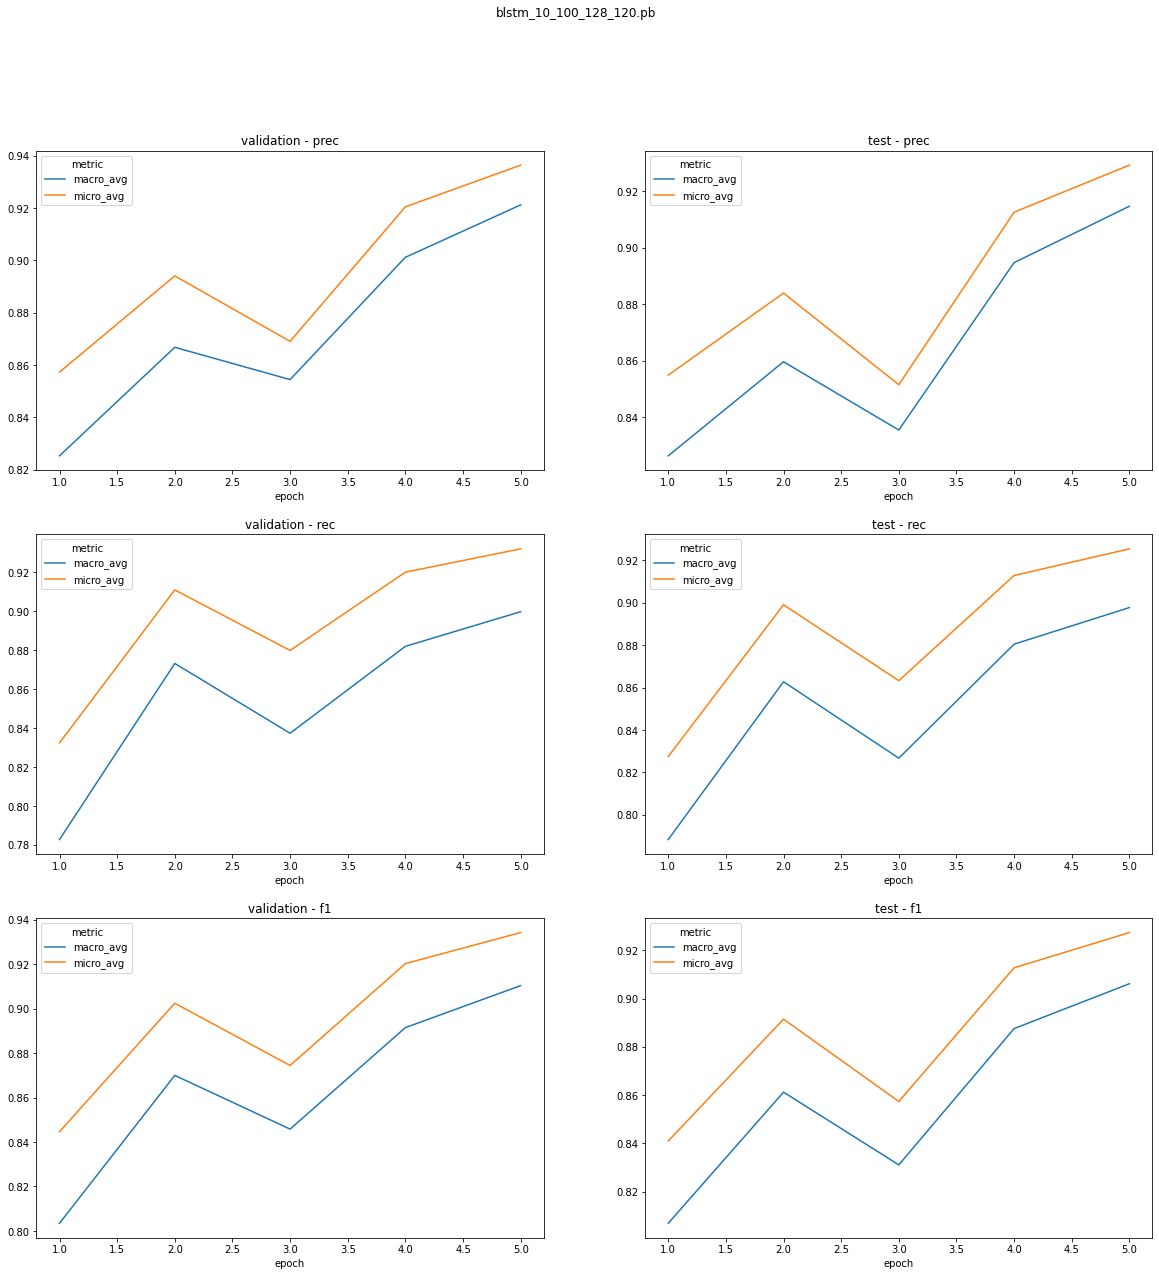

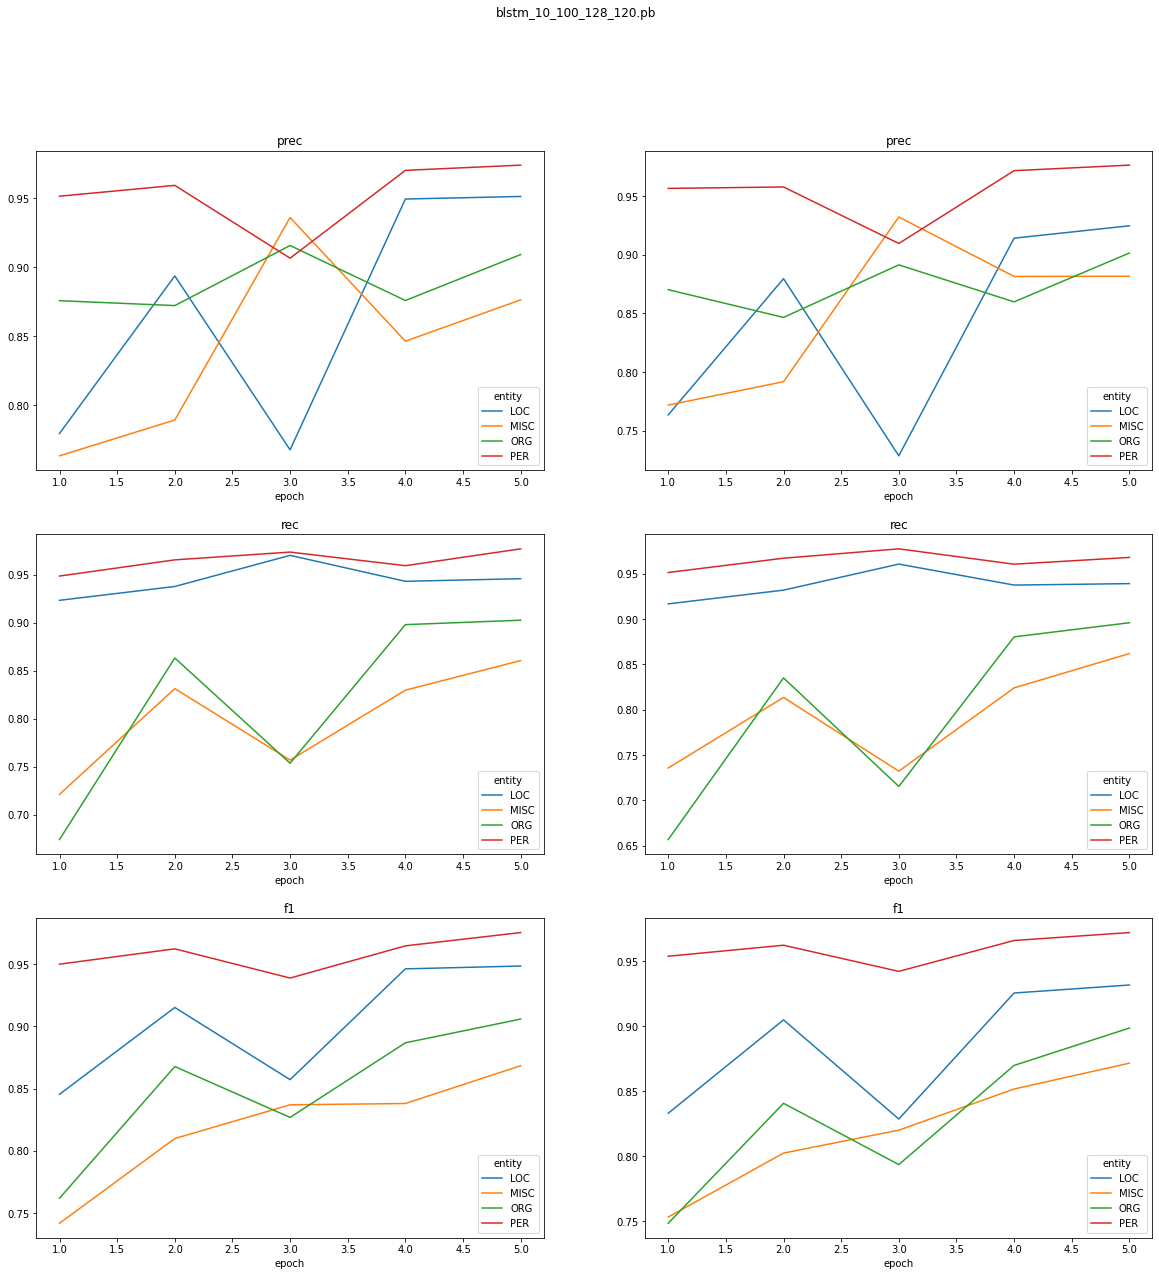

In [0]:
ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

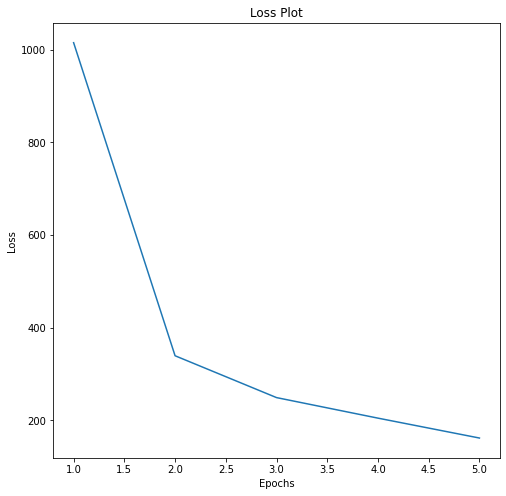

In [0]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

### Saving the trained model

In [0]:
ner_model.stages

Out[47]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_a6d68dcf1fb4]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 5000
drwxr-xr-x 1 root root 4096 Feb 8 19:24 .
drwxr-xr-x 1 root root 4096 Feb 8 18:48 ..
drwxr-xr-x 2 root root 4096 Feb 8 19:24 __pycache__
drwxr-xr-x 1 root root 4096 Feb 8 18:48 conf
-rw-r--r-- 1 root root 7431 Feb 8 19:12 conll_eval.py
-rw-r--r-- 1 root root 1545 Feb 8 18:51 create_graph.py
-rw-r--r-- 1 root root 2543 Feb 8 18:51 dataset_encoder.py
-rw-r--r-- 1 root root 827443 Feb 8 19:07 eng.testa
-rw-r--r-- 1 root root 3283420 Feb 8 19:07 eng.train
drwxr-xr-x 3 root root 4096 Feb 8 18:49 eventlogs
drwxr-xr-x 2 root root 4096 Feb 8 19:15 ganglia
drwxr-xr-x 2 root root 4096 Feb 8 19:01 logs
-rw-r--r-- 1 root root 3826 Feb 8 19:24 ner_log_parser.py
-rw-r--r-- 1 root root 21853 Feb 8 18:51 ner_model.py
-rw-r--r-- 1 root root 2484 Feb 8 18:51 ner_model_saver.py
-r-xr-xr-x 1 root root 912170 Jan 1 1970 preload_class.lst
-rw-r--r-- 1 root root 953 Feb 8 18:51 sentence_grouper.py

In [0]:
ner_model.stages[1].write().overwrite().save('/databricks/driver/models/NerDLModel_340')

## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("/databricks/driver/models/NerDLModel_340")\
     .setInputCols(["sentence", "token", "embeddings"])\
     .setOutputCol("ner")

converter = NerConverter()\
      .setInputCols(["document", "token", "ner"])\
      .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
text |
+-------------------------------------------------+
Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+

In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
Peter Parker|PER |
New York |LOC |
+------------+------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

Out[55]: [('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[56]:

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# Creating your own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ][ / ][ — ][OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ][ / ][ — ][ \ ][OK!]
Spark NLP NER lightpipeline is created

In [0]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O

# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
%tensorflow_version 1.x

from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py
import sys
sys.path.append('/databricks/driver/')
sys.path.append('/databricks/driver/create_graph.py')
import create_graph
ntags = 19 # number of labels
embeddings_dim = 100
nchars =100
create_graph.create_graph(ntags, embeddings_dim, nchars)

End of Notebook #